In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.constants import c
from scipy.signal import fftconvolve
from scipy.signal.windows import hamming, blackman, kaiser
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import csv
from funcs import read_iq_bin, notch_filter, gen_chirp_to_csv_rep, spectrogram_data, extract_signals_from_bin, read_complex_csv, gen_chirp_to_csv, gen_nlfm_to_csv
pulse_width = 5000
pulse_separation = 0
B = 12e6

# Pulse Integration

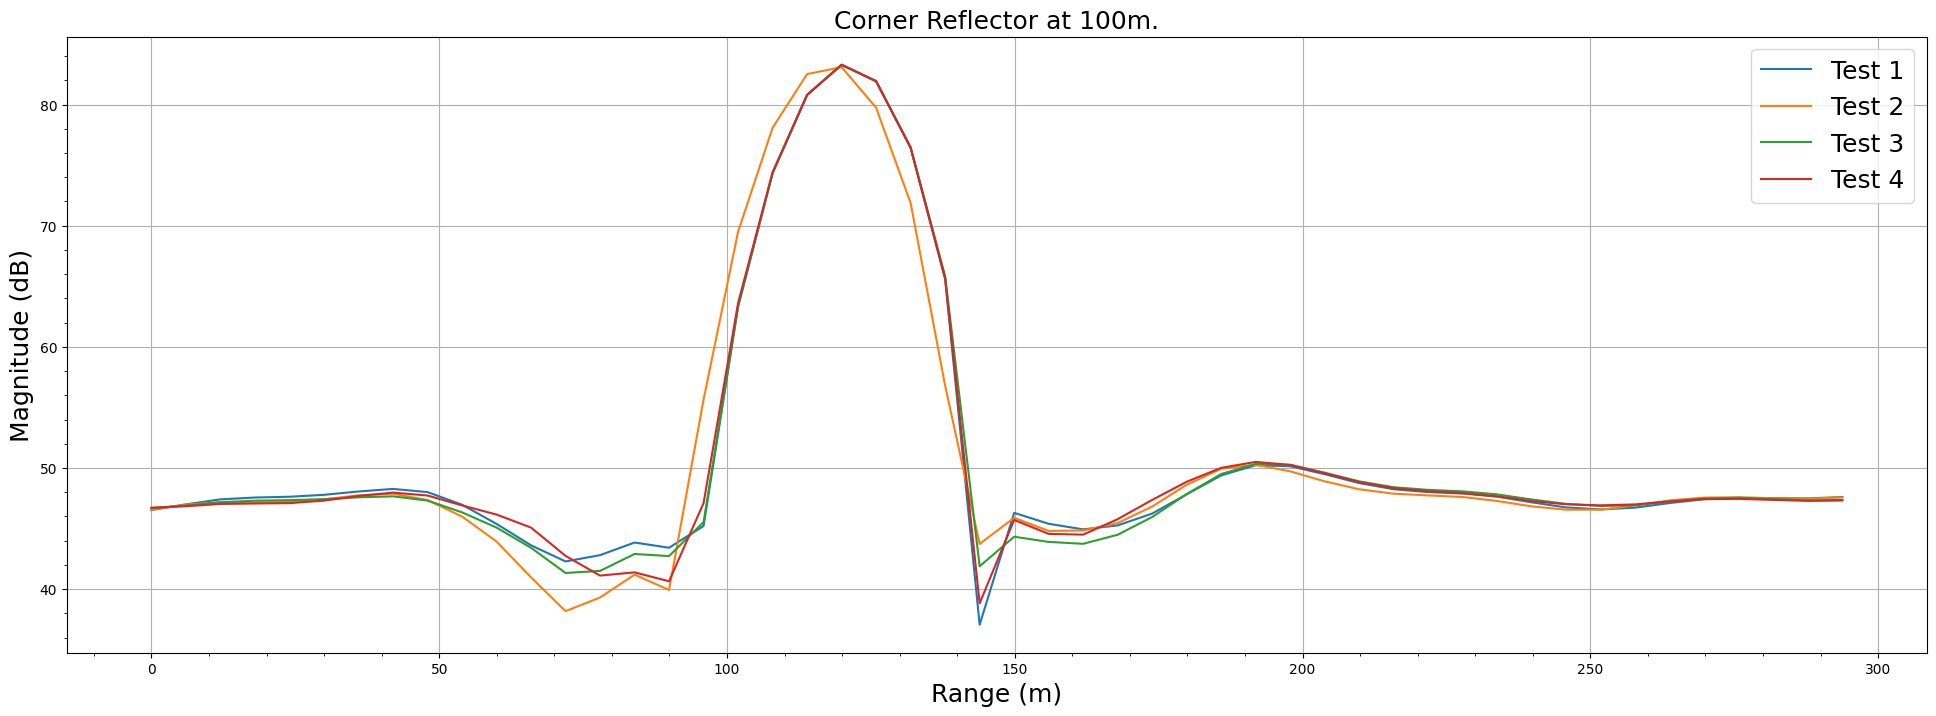

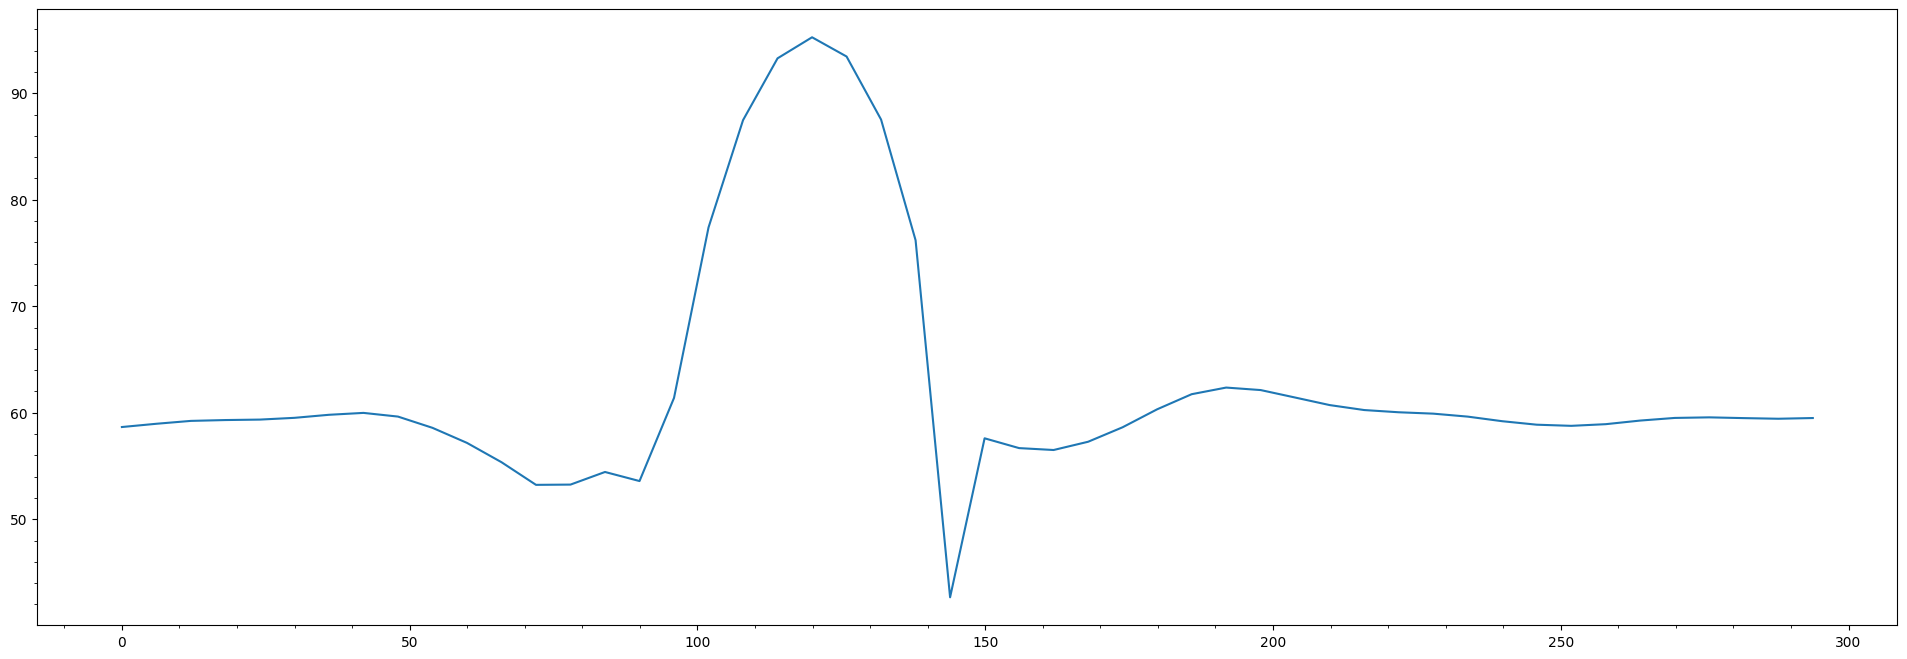

In [22]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]


def cpi(file_path, template_signal):
    data = read_iq_bin(file_path)
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(data, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full
    # Extract pulses
    pulse_sum = np.zeros(50).astype(np.complex128)
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx-20:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:50]
        if (len(xcorr_data_plot)==50):
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        else:
            break
    return pulse_sum

ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]

d = 100
pulse_sum_0 = cpi(f"../outputs/outputs5/field_cr_{d}m_0.bin",template_signal)
pulse_sum_1 = cpi(f"../outputs/outputs5/field_cr_{d}m_1.bin",template_signal)
pulse_sum_2 = cpi(f"../outputs/outputs5/field_cr_{d}m_2.bin",template_signal)
pulse_sum_3 = cpi(f"../outputs/outputs5/field_cr_{d}m_3.bin",template_signal)

pulse_sum = pulse_sum_0 + pulse_sum_1 + pulse_sum_2 + pulse_sum_3

range_bins = np.arange(len(pulse_sum))

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_0)), label="Test 1")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_1)), label="Test 2")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_2)), label="Test 3")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_3)), label="Test 4")
plt.title(f"Corner Reflector at {d}m.", fontsize=18)
plt.minorticks_on()
#plt.xticks(range_bins)
plt.grid()
plt.legend(fontsize=18)
plt.xlabel("Range (m)", fontsize=18)
plt.ylabel("Magnitude (dB)", fontsize=18)
plt.show()

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.show()


# Fieldfox

Frequency from 2500000000 to 3000000000


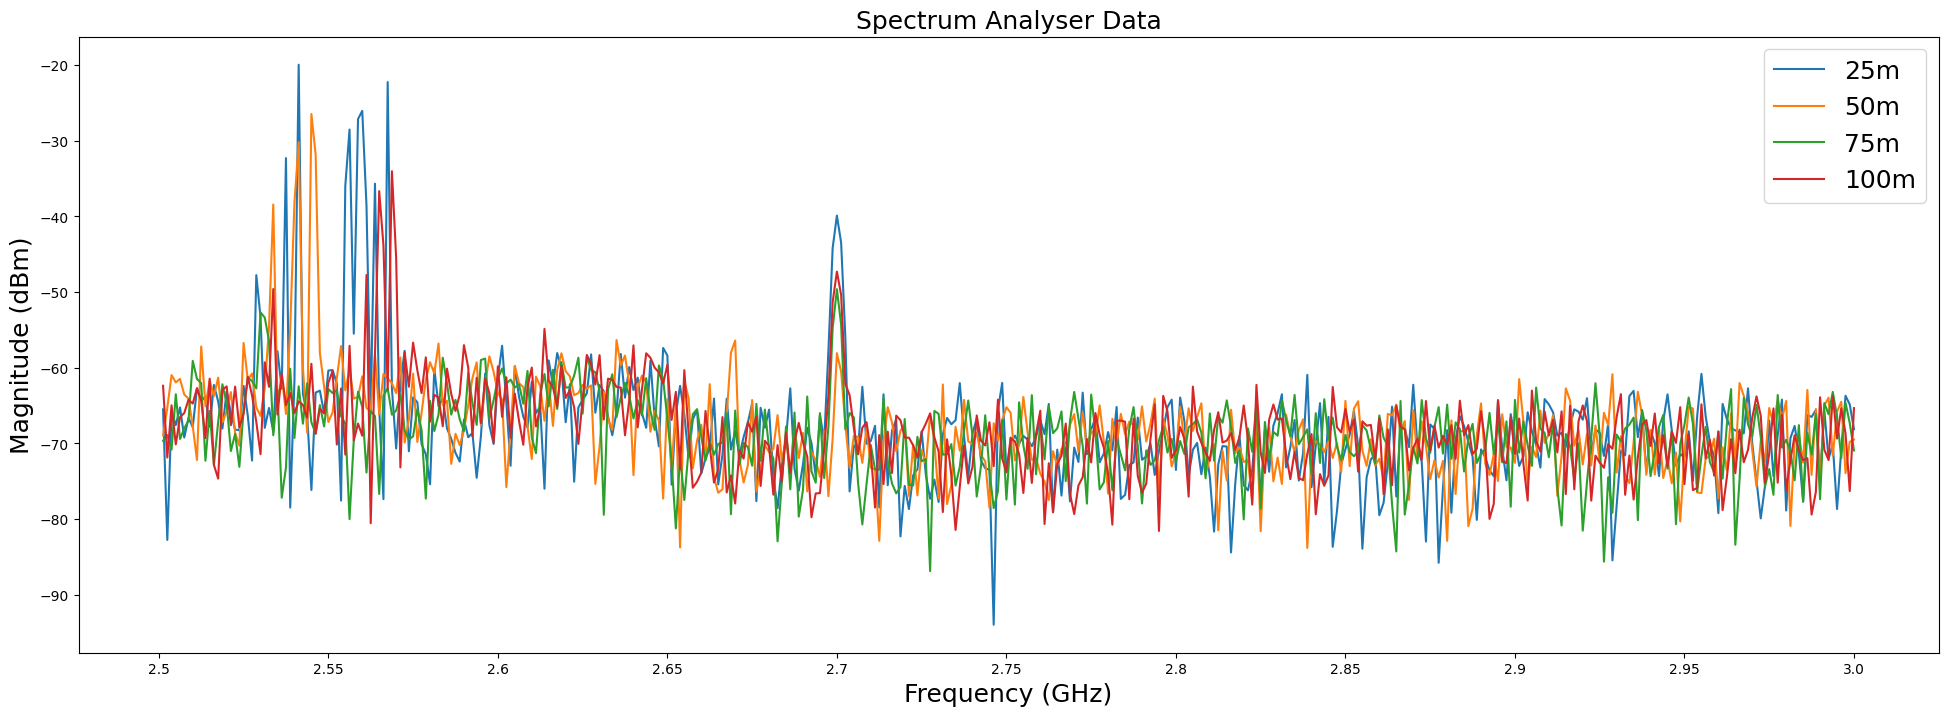

In [55]:
data_25 = pd.read_csv('../outputs/outputs5/25.csv')
data_50 = pd.read_csv('../outputs/outputs5/50.csv')
data_75 = pd.read_csv('../outputs/outputs5/75.csv')
data_100 = pd.read_csv('../outputs/outputs5/100.csv')

# Assuming the first column is 'X' and the second column is 'Y'
x_25 = data_25.iloc[:, 0]  # First column
y_25 = data_25.iloc[:, 1]  # Second column
x_50 = data_50.iloc[:, 0]  # First column
y_50 = data_50.iloc[:, 1]  # Second column
x_75 = data_75.iloc[:, 0]  # First column
y_75 = data_75.iloc[:, 1]  # Second column
x_100 = data_100.iloc[:, 0]  # First column
y_100 = data_100.iloc[:, 1]  # Second column

# Defining x tick interval
min_x = round(x_25.min(),-8)
max_x = x_25.max()
print(f"Frequency from {min_x} to {max_x}")
tick_interval = 50000000
ticks = np.arange(min_x, max_x + tick_interval, tick_interval)
tick_labels = ticks / 1e9

# Place marker where x is closest to 2.7 GHz (2.7 * 1e9 Hz)
#target_x = 2.7 * 1e9
#closest_index = (np.abs(x - target_x)).idxmin()  # Find the closest index
#closest_y_value = y[closest_index]

plt.figure(figsize=(24,8))
plt.title("Spectrum Analyser Data", fontsize=18)
plt.plot(x_25,y_25, label="25m")
plt.plot(x_50,y_50, label="50m")
plt.plot(x_75,y_100, label="75m")
plt.plot(x_100,y_75, label="100m")
#plt.plot(x[closest_index], y[closest_index], marker='o', markersize=10, color='red')
#plt.text(x[closest_index], y[closest_index]+1, f'2.7 GHz: {closest_y_value:.2f} dBm', 
#         fontsize=18, color='red', ha='left', va='bottom')
plt.xticks(ticks=ticks, labels=tick_labels)
plt.ylabel("Magnitude (dBm)", fontsize=18)
plt.xlabel("Frequency (GHz)", fontsize=18)
plt.legend(fontsize=18)
plt.show()

# Insert Spectrogram and FFT

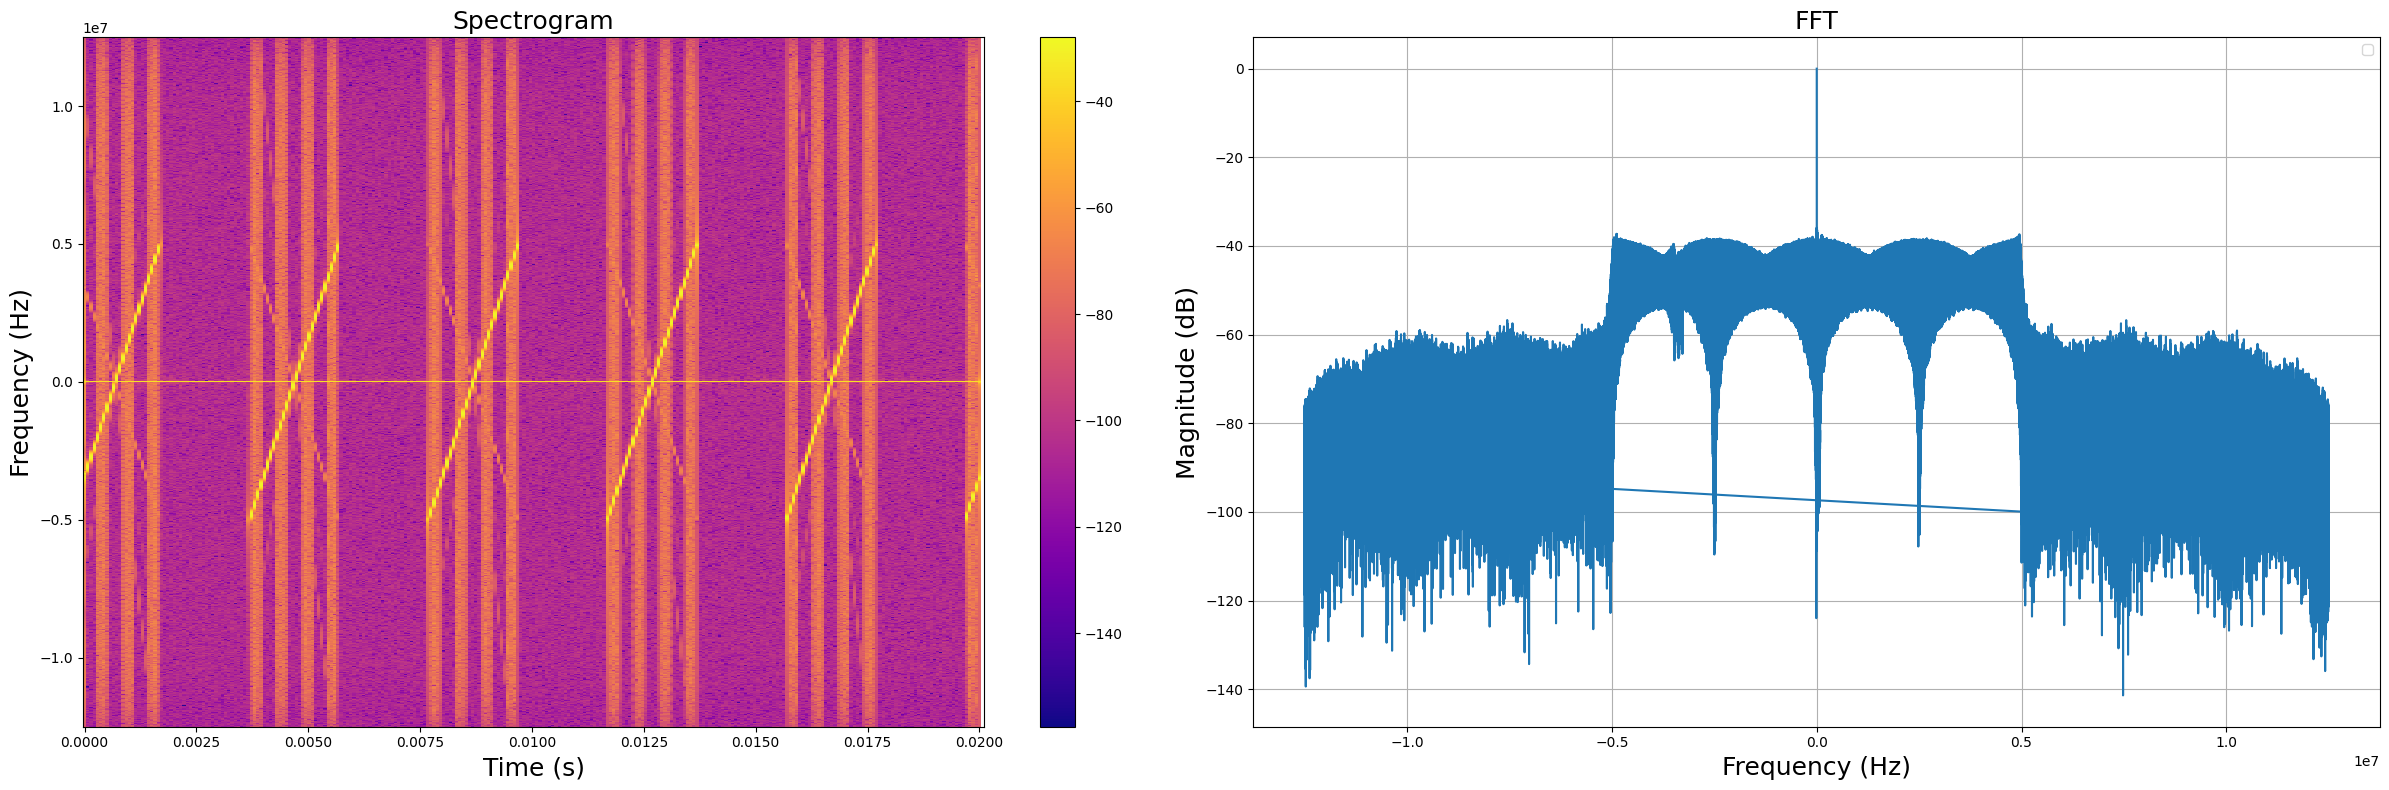

In [15]:
complex_data = read_iq_bin("../outputs/outputs6/loopback_from_file.bin")
fs = 25e6

# Plotting spectrogram
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(complex_data,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)', fontsize=18)
axs[0].set_ylabel('Frequency (Hz)', fontsize=18)
axs[0].set_title('Spectrogram', fontsize=18)

# plotting fft
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude/np.max(magnitude))

axs[1].plot(fft_freq_axis, magnitude_db)
axs[1].set_title('FFT', fontsize=18)
axs[1].set_xlabel("Frequency (Hz)", fontsize=18)
axs[1].set_ylabel("Magnitude (dB)", fontsize=18)
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()



# Just Rx

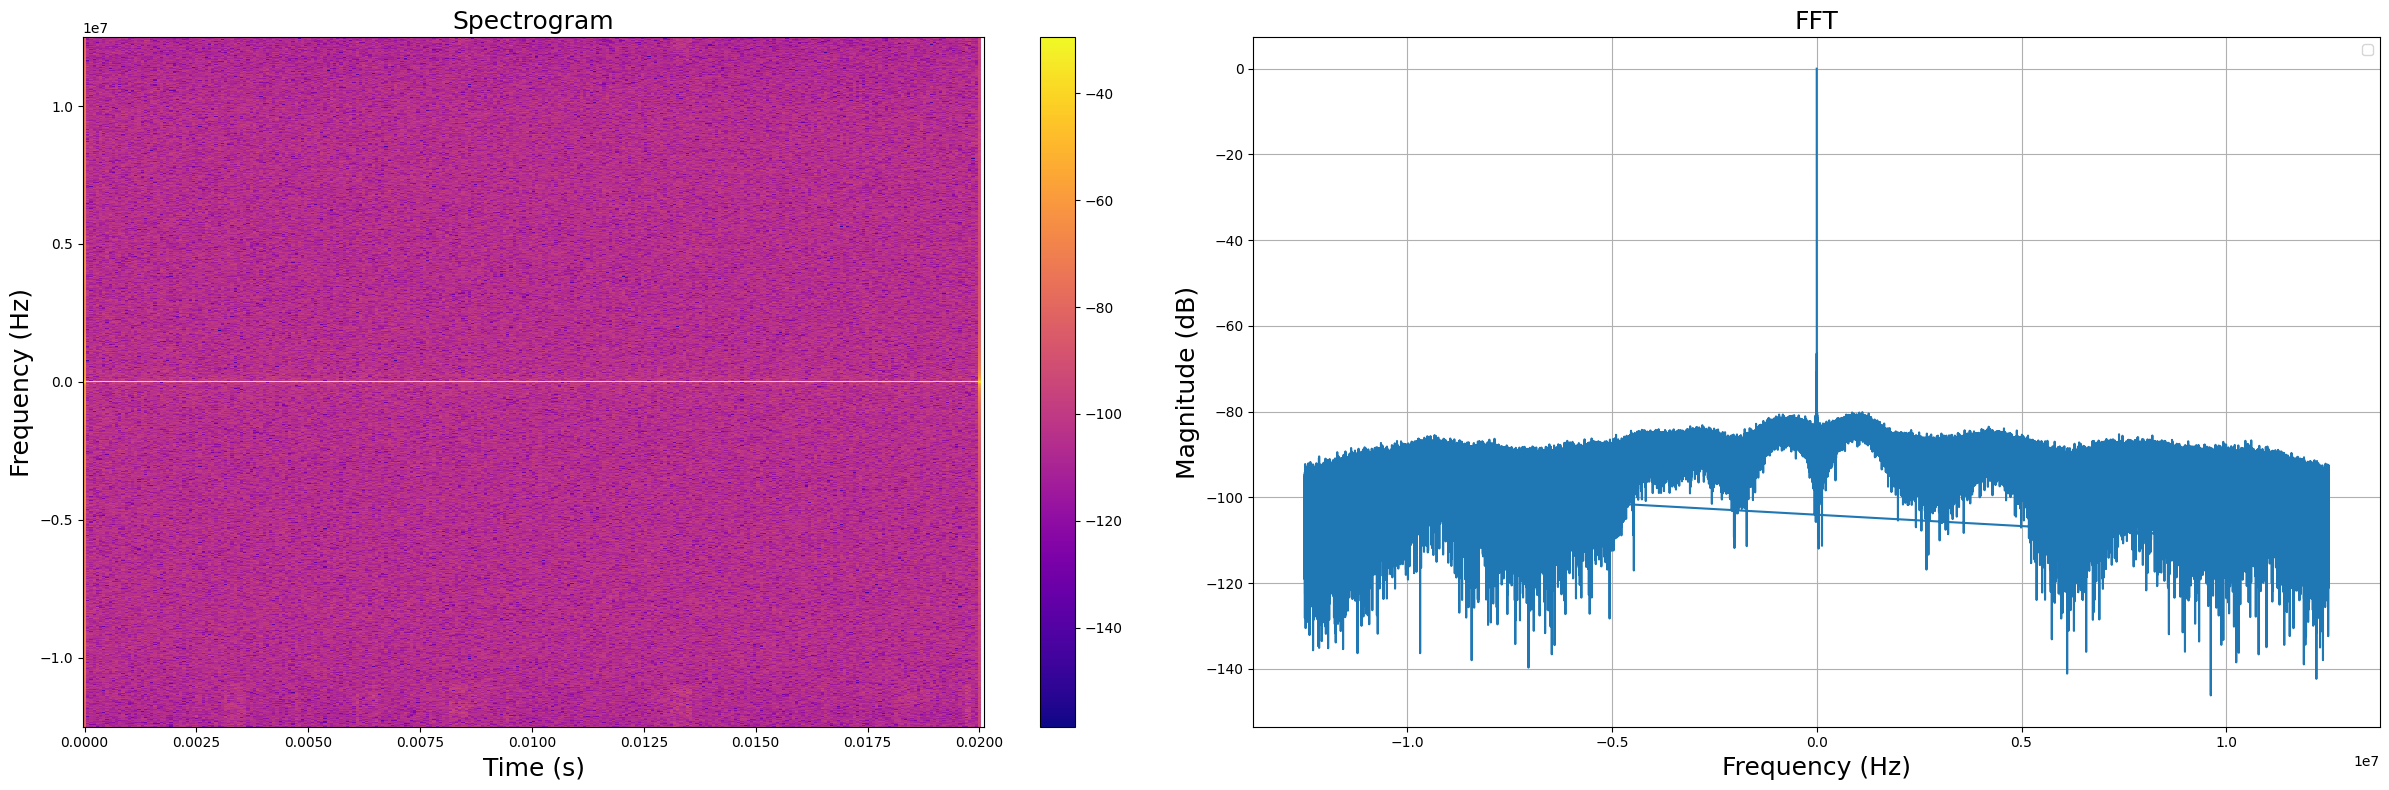

In [34]:
complex_data = read_iq_bin("../outputs/outputs5/field_rx_0.bin")
fs = 25e6

# Plotting spectrogram
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
times, frequencies_shifted, magnitude_spectrogram_db = spectrogram_data(complex_data,fs)
cax0 = axs[0].pcolormesh(times, frequencies_shifted, magnitude_spectrogram_db, shading='auto', cmap='plasma')
#axs[0].set_colorbar(label='Magnitude (dB)')
axs[0].set_xlabel('Time (s)', fontsize=18)
axs[0].set_ylabel('Frequency (Hz)', fontsize=18)
axs[0].set_title('Spectrogram', fontsize=18)

# plotting fft
fft_data = np.fft.fft(complex_data)
fft_freq_axis = np.fft.fftfreq(len(fft_data),d=1/fs)

# convert to db
magnitude = np.abs(fft_data)
magnitude_db = 20 * np.log10(magnitude/np.max(magnitude))

axs[1].plot(fft_freq_axis, magnitude_db)
axs[1].set_title('FFT', fontsize=18)
axs[1].set_xlabel("Frequency (Hz)", fontsize=18)
axs[1].set_ylabel("Magnitude (dB)", fontsize=18)
axs[1].legend()
axs[1].grid(True)

fig.colorbar(cax0, ax=axs[0])
plt.tight_layout()
plt.show()



# Lab tests

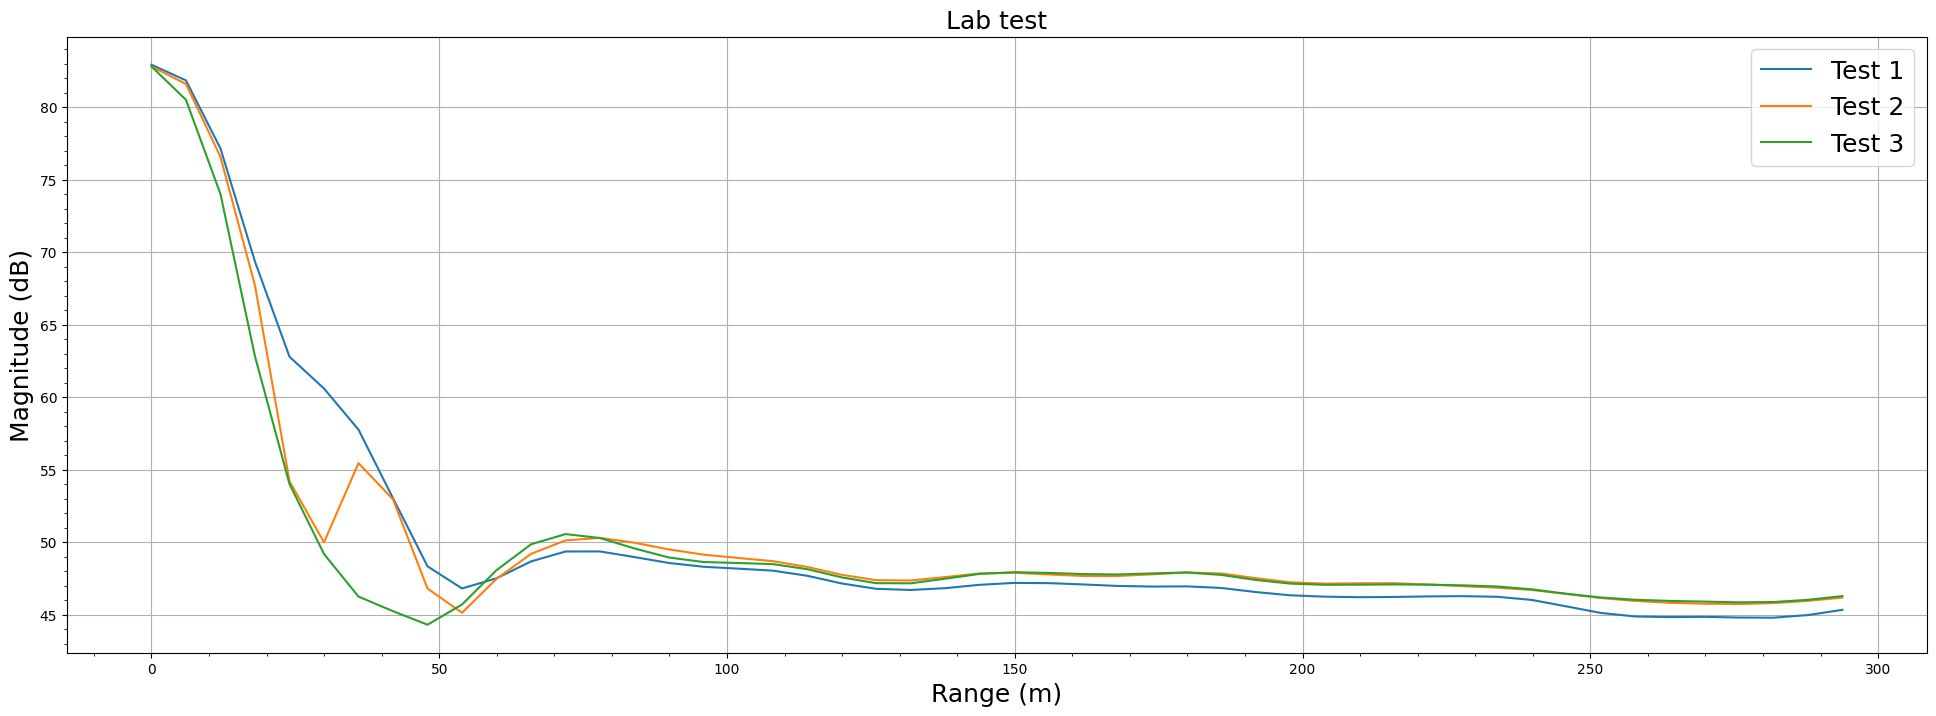

In [23]:
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]


def cpi(file_path, template_signal):
    data = read_iq_bin(file_path)
    matched_filter = np.conjugate(template_signal[::-1])
    window = hamming(len(matched_filter))  # Choose the appropriate window function
    window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
    matched_filter = matched_filter * window  # Apply the window
    xcorr_data = fftconvolve(data, matched_filter, mode='full')
    xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full
    # Extract pulses
    pulse_sum = np.zeros(50).astype(np.complex128)
    while (len(xcorr_data)>0):
        max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
        xcorr_data_plot = xcorr_data[max_idx:max_idx+pulse_width]
        xcorr_data_plot = xcorr_data_plot[0:50]
        if (len(xcorr_data_plot)==50):
            pulse_sum += xcorr_data_plot
            xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        else:
            break
    return pulse_sum

ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]

pulse_sum_0 = cpi(f"../outputs/outputs4/lab_cr_0.bin",template_signal)
pulse_sum_1 = cpi(f"../outputs/outputs4/lab_cr_1.bin",template_signal)
pulse_sum_2 = cpi(f"../outputs/outputs4/lab_cr_2.bin",template_signal)

range_bins = np.arange(len(pulse_sum))

plt.figure(figsize=(24,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_0)), label="Test 1")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_1)), label="Test 2")
plt.plot(ranges,20*np.log10(np.abs(pulse_sum_2)), label="Test 3")
plt.title("Lab test", fontsize=18)
plt.minorticks_on()
#plt.xticks(range_bins)
plt.grid()
plt.legend(fontsize=18)
plt.xlabel("Range (m)", fontsize=18)
plt.ylabel("Magnitude (dB)", fontsize=18)
plt.show()


# Tx Test

Frequency from 2000000000 to 3000000000


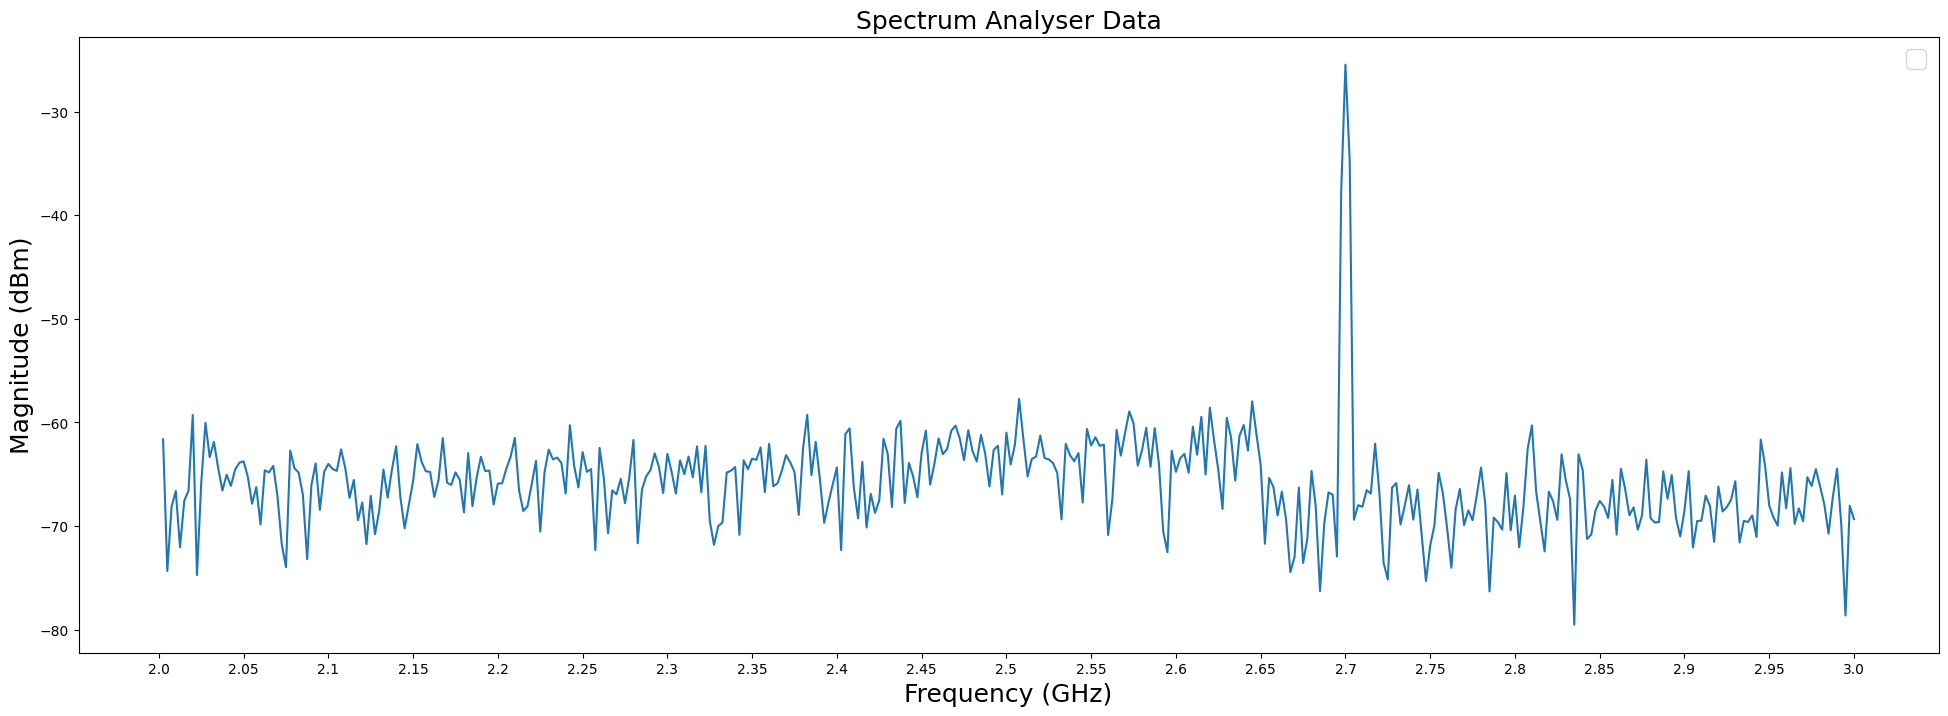

In [12]:
data = pd.read_csv('../outputs/outputs6/TX.csv') 

# Assuming the first column is 'X' and the second column is 'Y'
x = data.iloc[:, 0]  # First column
y = data.iloc[:, 1]  # Second column


# Defining x tick interval
min_x = round(x.min(),-8)
max_x = x.max()
print(f"Frequency from {min_x} to {max_x}")
tick_interval = 50000000
ticks = np.arange(min_x, max_x + tick_interval, tick_interval)
tick_labels = ticks / 1e9

# Place marker where x is closest to 2.7 GHz (2.7 * 1e9 Hz)
#target_x = 2.7 * 1e9
#closest_index = (np.abs(x - target_x)).idxmin()  # Find the closest index
#closest_y_value = y[closest_index]

plt.figure(figsize=(24,8))
plt.title("Spectrum Analyser Data", fontsize=18)
plt.plot(x,y)
plt.xticks(ticks=ticks, labels=tick_labels)
plt.ylabel("Magnitude (dBm)", fontsize=18)
plt.xlabel("Frequency (GHz)", fontsize=18)
plt.legend(fontsize=18)
plt.show()

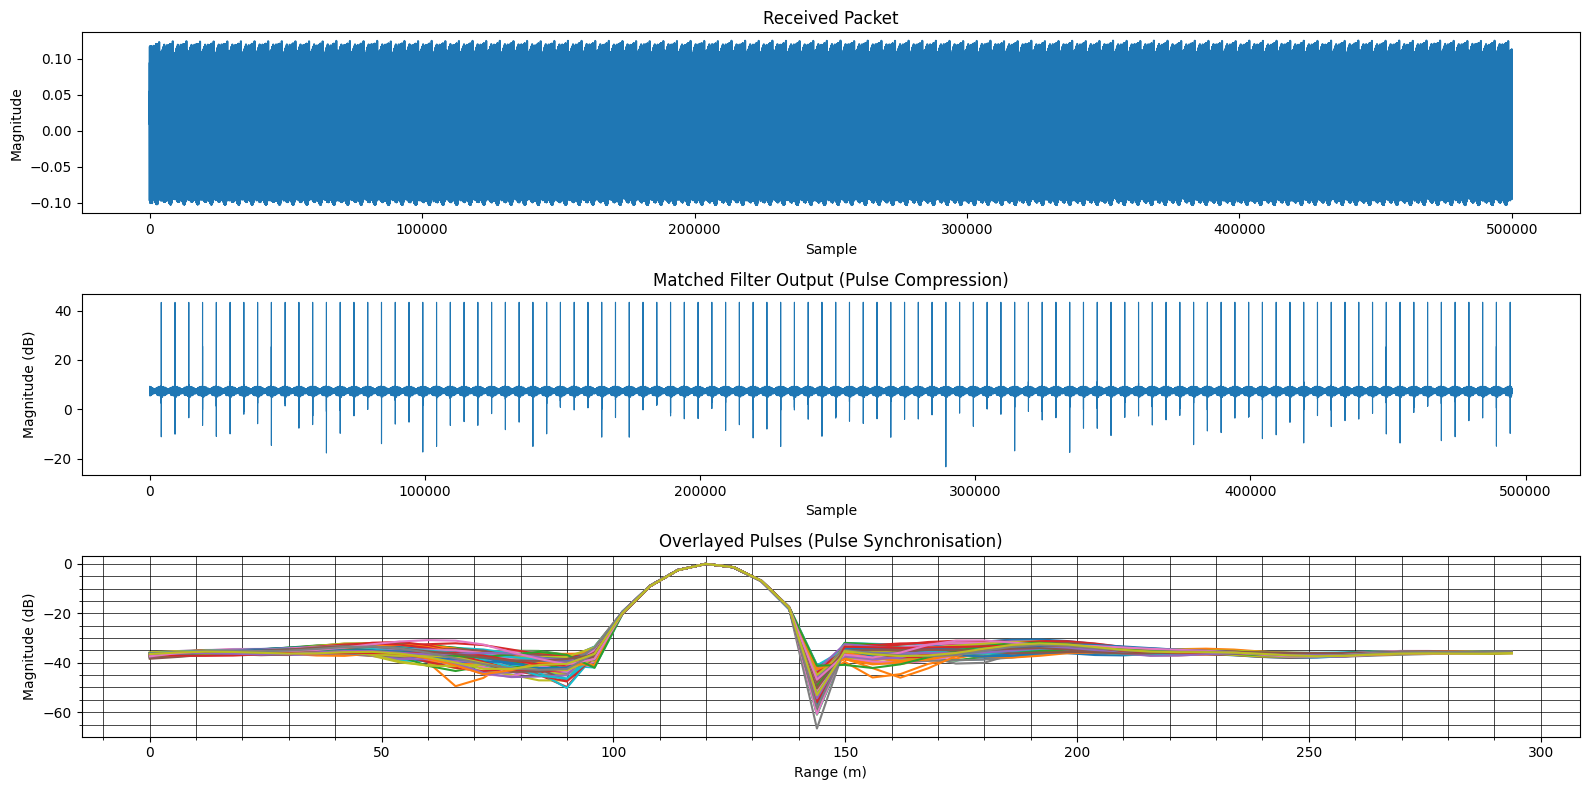

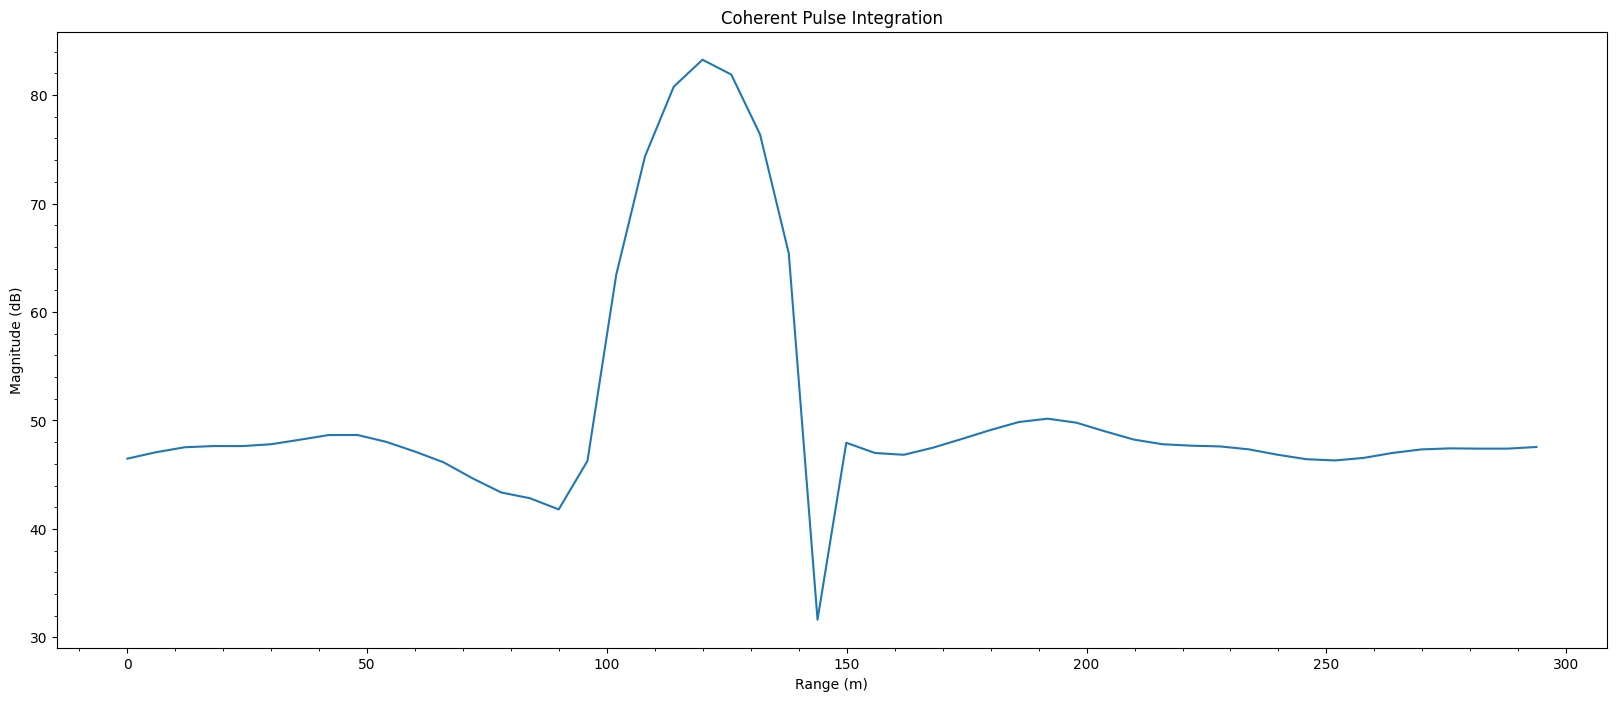

99


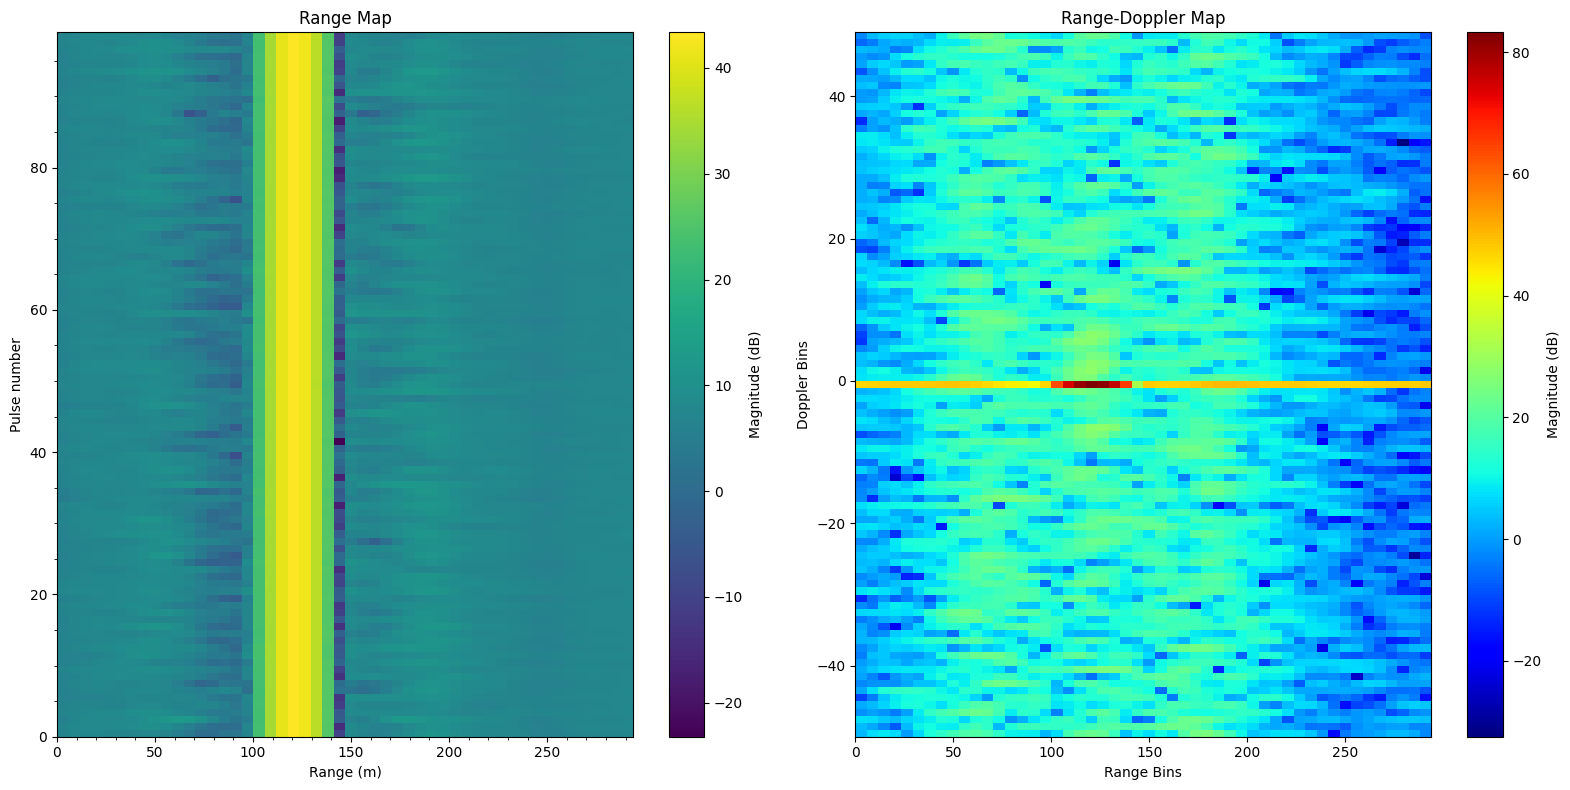

In [5]:
data = read_iq_bin("../outputs/outputs5/field_cr_75m_1.bin")
#data = read_iq_bin("../outputs/pulsed_test.bin")
template_signal = read_complex_csv("../sweep.csv")
template_signal = template_signal[0:pulse_width]
#data = data[50000:]

fig, axs = plt.subplots(3, 1, figsize=(16, 8))

axs[0].plot(data)
axs[0].set_title("Received Packet")
axs[0].set_xlabel("Sample")
axs[0].set_ylabel("Magnitude")

# Matched filter
matched_filter = np.conjugate(template_signal[::-1])
window = hamming(len(matched_filter))  # Choose the appropriate window function
window = kaiser(len(matched_filter), 20, sym=True)  # Choose the appropriate window function
matched_filter = matched_filter * window  # Apply the window
xcorr_data = fftconvolve(data, matched_filter, mode='full')
xcorr_data = xcorr_data[5000:-5000] # Artifact at start from mode=full
axs[1].plot(20*np.log10(np.abs(xcorr_data)),linewidth=0.8)
axs[1].set_title("Matched Filter Output (Pulse Compression)")
axs[1].set_xlabel("Sample")
axs[1].set_ylabel("Magnitude (dB)")

# Extract pulses
xcorr_matrix = []
ranges = np.arange(len(template_signal)) * c / (2*25e6)
ranges = ranges[0:50]
pulse_sum = np.zeros(50).astype(np.complex128)
while (len(xcorr_data)>0):
    max_idx = np.argmax(np.abs(xcorr_data[0:pulse_width+pulse_separation]))
    xcorr_data_plot = xcorr_data[max_idx-20:max_idx+pulse_width]
    xcorr_data_plot = xcorr_data_plot[0:50]
    if (len(xcorr_data_plot)==50):
        axs[2].plot(ranges,20*np.log10(np.abs(xcorr_data_plot/np.max(xcorr_data_plot))))
        pulse_sum += xcorr_data_plot
        xcorr_data = xcorr_data[pulse_width+pulse_separation:]
        xcorr_matrix.append(xcorr_data_plot)
    else:
        break

#axs[2].set_xticks(ranges)
axs[2].grid(True, which='both')
axs[2].grid(which='minor', linewidth=0.5, color='black')
axs[2].grid(which='major', linewidth=0.5, color='black')
axs[2].minorticks_on()
#plt.setp(axs[2].get_xticklabels(), fontsize=4)
axs[2].set_title("Overlayed Pulses (Pulse Synchronisation)")
axs[2].set_xlabel("Range (m)")
axs[2].set_ylabel("Magnitude (dB)")

plt.tight_layout()
plt.show()

plt.figure(figsize=(20,8))
plt.plot(ranges,20*np.log10(np.abs(pulse_sum)))
plt.minorticks_on()
plt.title("Coherent Pulse Integration")
plt.xlabel("Range (m)")
plt.ylabel("Magnitude (dB)")
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Range map
im_range = axs[0].imshow(20*np.log10(np.abs(xcorr_matrix)), extent=[ranges[0], ranges[-1], 0, len(xcorr_matrix)], aspect='auto', cmap='viridis') 
axs[0].minorticks_on()
axs[0].set_ylabel("Pulse number")
axs[0].set_xlabel("Range (m)")
axs[0].set_title("Range Map")


# Range-doppler
num_pulses = len(xcorr_matrix)
print(num_pulses)
num_range_bins = len(xcorr_matrix[0])

doppler_fft = np.fft.fftshift(np.fft.fft(xcorr_matrix, axis=0), axes=0)
range_doppler_map = 20 * np.log10(np.abs(doppler_fft))

im_rd = axs[1].imshow(range_doppler_map, extent=[ranges[0], ranges[-1], -num_pulses//2, num_pulses//2],
           aspect='auto', cmap='jet', origin='lower')
axs[1].set_title('Range-Doppler Map')
axs[1].set_xlabel('Range Bins')
axs[1].set_ylabel('Doppler Bins')

cbar = plt.colorbar(im_range, ax=axs[0])
cbar.set_label('Magnitude (dB)')  # Set the label for the colorbar
cbar = plt.colorbar(im_rd, ax=axs[1])
cbar.set_label('Magnitude (dB)')  # Set the label for the colorbar
plt.tight_layout()
plt.show()


# Pink noise (phase noise)

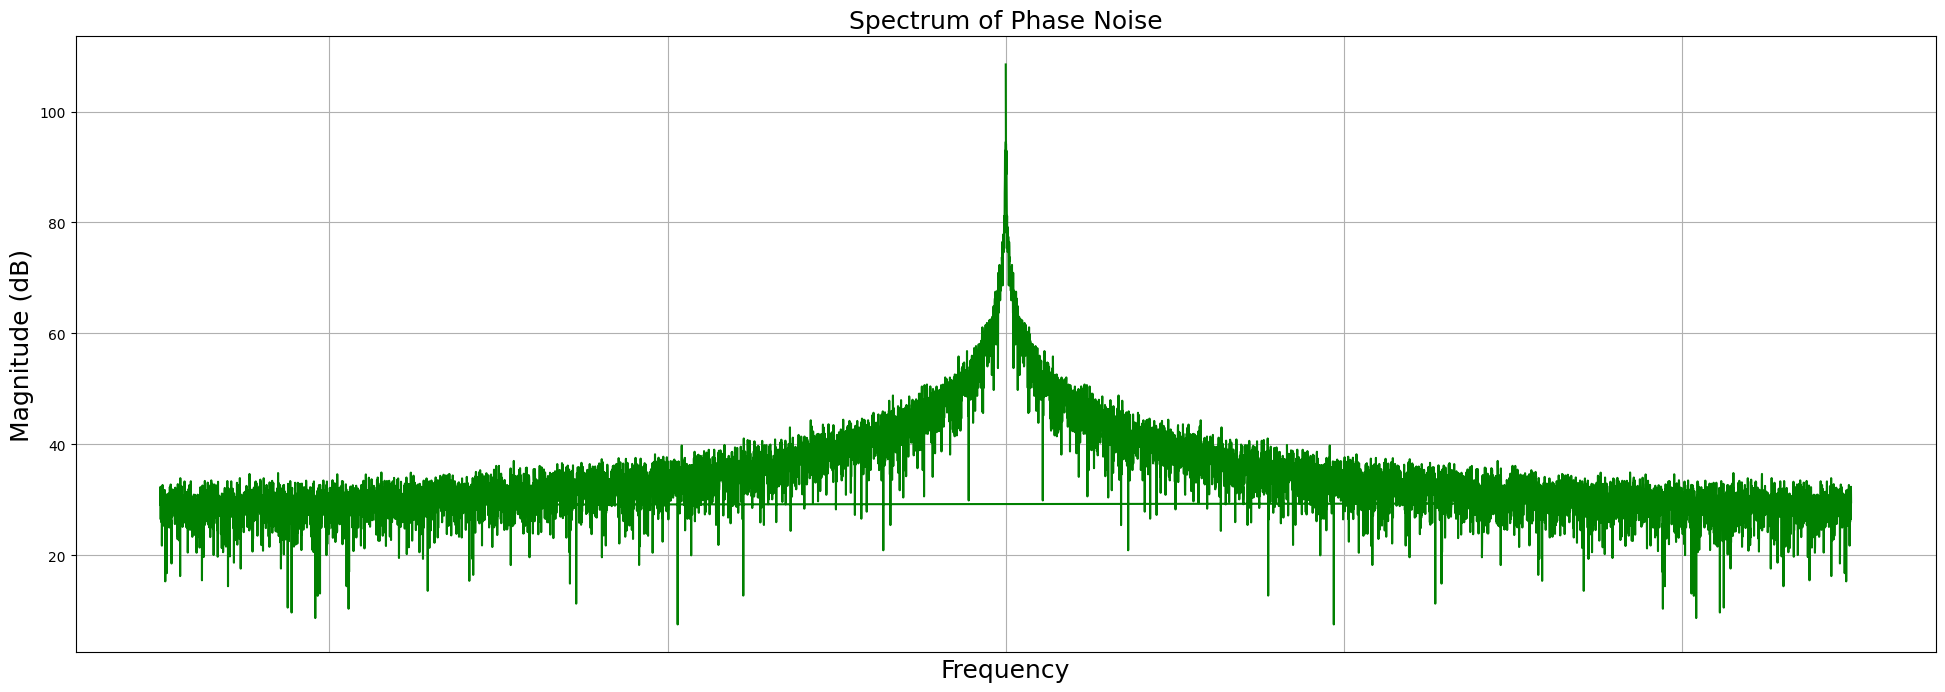

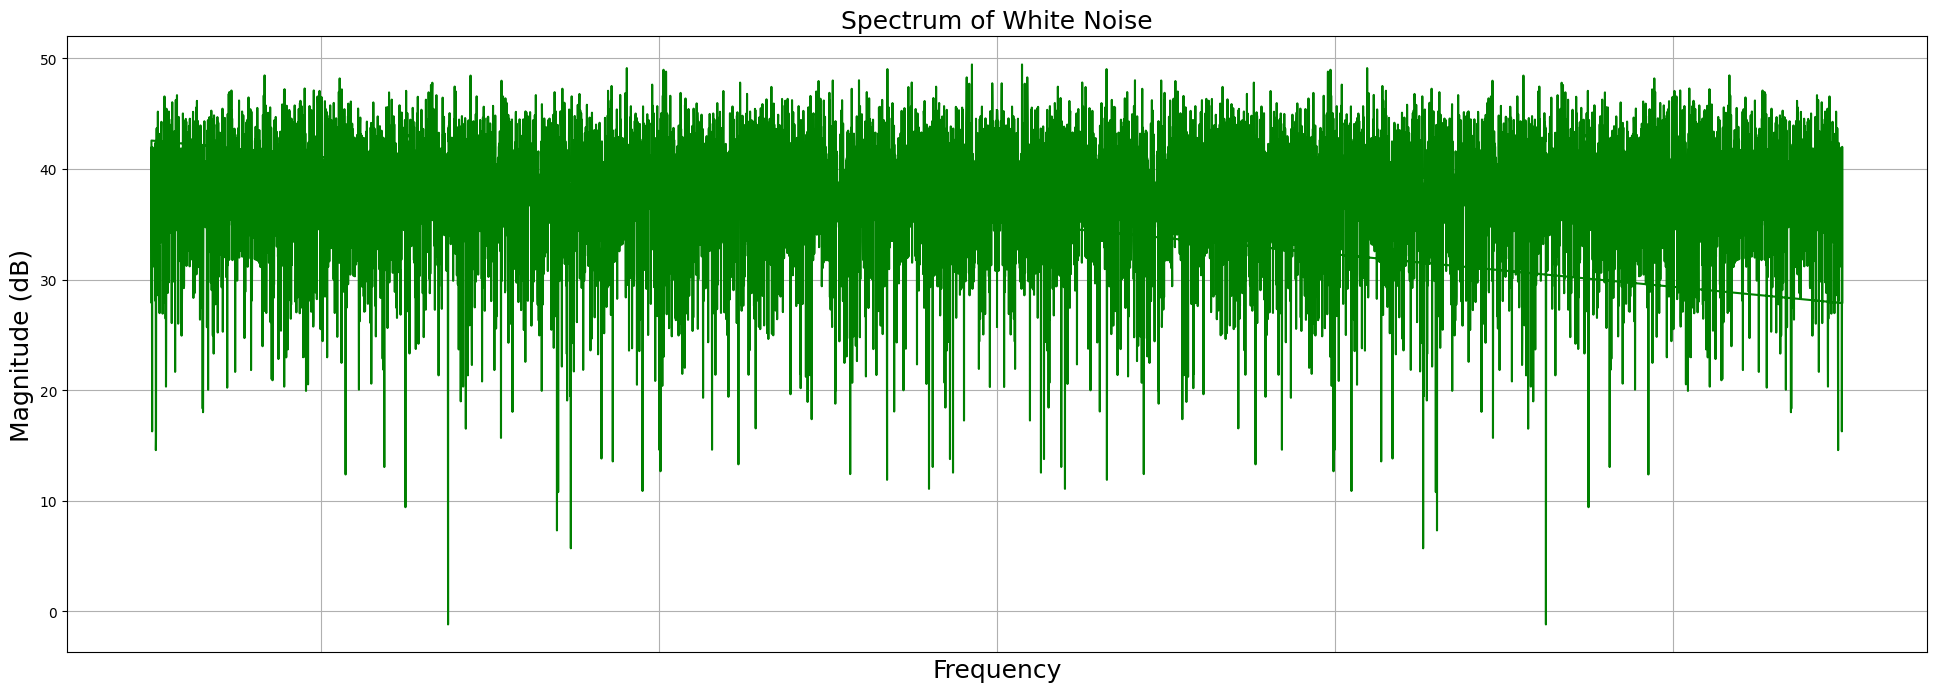

In [15]:
# Function to generate pink noise using the Voss-McCartney algorithm
def generate_pink_noise(num_samples):
    num_rows = 16  # Number of random sources
    array = np.random.randn(num_rows, num_samples)  # Generate white noise
    pink_noise = np.zeros(num_samples)
    
    for i in range(num_rows):
        pink_noise += np.cumsum(array[i])
    
    pink_noise /= num_rows  # Average the summed values
    
    return pink_noise

# Generate pink noise
num_samples = 10000
pink_noise = generate_pink_noise(num_samples)

# Perform FFT of the pink noise
fft_vals = np.fft.fft(pink_noise)
fft_freqs = np.fft.fftfreq(num_samples)

# Get the magnitude of the FFT (take the absolute value)
fft_magnitude = np.abs(fft_vals)
plt.figure(figsize=(24, 8))
plt.plot(fft_freqs, 20*np.log10(np.abs(fft_magnitude)), color='green')
plt.title('Spectrum of Phase Noise', fontsize=18)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Magnitude (dB)', fontsize=18)
plt.grid(True)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

# Generate white noise
num_samples = 10000
white_noise = np.random.normal(0, 1, num_samples)
fft_vals = np.fft.fft(white_noise)
fft_freqs = np.fft.fftfreq(num_samples)
fft_magnitude = np.abs(fft_vals)
plt.figure(figsize=(24, 8))
plt.plot(fft_freqs, 20*np.log10(np.abs(fft_magnitude)), color='green')
plt.title('Spectrum of White Noise',fontsize=18)
plt.xlabel('Frequency',fontsize=18)
plt.ylabel('Magnitude (dB)',fontsize=18)
plt.grid(True)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()